In [1]:
import os

# Go one level up to Bone_Fracture_Localization
os.chdir('..')

# Confirm you're in the right place
print("Now in:", os.getcwd())


Now in: c:\Users\jaswa\Downloads\Bone_Fracture_Localization


In [2]:
import os
import re
import copy
import time
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as TF

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)


In [3]:
import os
import pandas as pd

# Base path to your local MURA dataset folder
BASE_PATH = "MURA-v1.1"

# Quick checks
print("Base path:", BASE_PATH)
print("Folder exists:", os.path.isdir(BASE_PATH))
print("Train CSV exists:", os.path.isfile(os.path.join(BASE_PATH, "train_labeled_studies.csv")))
print("Valid CSV exists:", os.path.isfile(os.path.join(BASE_PATH, "valid_labeled_studies.csv")))

import os
import pandas as pd

def load_study_csv(csv_filename, base_path='MURA-v1.1'):
    csv_path = os.path.join(base_path, csv_filename)
    if not os.path.isfile(csv_path):
        raise FileNotFoundError(f"CSV not found: {csv_path}")

    df = pd.read_csv(csv_path, header=None, names=['path', 'label'])
    df['path'] = df['path'].astype(str).str.strip()
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)

    image_paths = []
    labels = []

    for _, row in df.iterrows():
        rel_or_abs = str(row['path'])
        study_path = os.path.normpath(rel_or_abs if rel_or_abs.startswith(base_path)
                                      else os.path.join(base_path, rel_or_abs))

        if not os.path.isdir(study_path):
            print(f"Skipping missing directory: {study_path}")
            continue

        for fname in os.listdir(study_path):
            if fname.startswith('._') or fname.startswith('.'):
                continue
            if not fname.lower().endswith('.png'):
                continue
            full_path = os.path.join(study_path, fname)
            try:
                if os.path.getsize(full_path) < 1024:
                    continue
            except OSError:
                continue
            image_paths.append(full_path)
            labels.append(int(row['label']))

    return pd.DataFrame({'image_path': image_paths, 'label': labels})


# Build per-image DataFrames
train_df = load_study_csv("train_labeled_studies.csv", base_path=BASE_PATH)
valid_df = load_study_csv("valid_labeled_studies.csv", base_path=BASE_PATH)

print("Train samples:", len(train_df))
print("Validation samples:", len(valid_df))
print(train_df.head())


Base path: MURA-v1.1
Folder exists: True
Train CSV exists: True
Valid CSV exists: True
Train samples: 36807
Validation samples: 3197
                                          image_path  label
0  MURA-v1.1\train\XR_SHOULDER\patient00001\study...      1
1  MURA-v1.1\train\XR_SHOULDER\patient00001\study...      1
2  MURA-v1.1\train\XR_SHOULDER\patient00001\study...      1
3  MURA-v1.1\train\XR_SHOULDER\patient00002\study...      1
4  MURA-v1.1\train\XR_SHOULDER\patient00002\study...      1


In [4]:
#@title U-Net bone segmentation (optional)
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1):
        super().__init__()
        self.d1 = DoubleConv(in_ch, 64)
        self.d2 = DoubleConv(64, 128)
        self.d3 = DoubleConv(128, 256)
        self.d4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.u1 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.c1 = DoubleConv(512, 256)
        self.u2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.c2 = DoubleConv(256, 128)
        self.u3 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.c3 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, out_ch, 1)
    def forward(self, x):
        c1 = self.d1(x); p1 = self.pool(c1)
        c2 = self.d2(p1); p2 = self.pool(c2)
        c3 = self.d3(p2); p3 = self.pool(c3)
        c4 = self.d4(p3)
        u1 = self.u1(c4); x1 = torch.cat([u1, c3], dim=1); c5 = self.c1(x1)
        u2 = self.u2(c5); x2 = torch.cat([u2, c2], dim=1); c6 = self.c2(x2)
        u3 = self.u3(c6); x3 = torch.cat([u3, c1], dim=1); c7 = self.c3(x3)
        return self.outc(c7)

def load_unet(device):
    model = UNet(in_ch=1, out_ch=1).to(device)
    model.eval()
    return model

def apply_bone_mask(image_np, model, device, thresh=0.5):
    with torch.no_grad():
        im = torch.from_numpy(image_np).float().unsqueeze(0).unsqueeze(0).to(device) / 255.0
        pred = torch.sigmoid(model(im))[0,0].cpu().numpy()
    mask = (pred > thresh).astype(np.uint8)
    masked = image_np * mask
    return masked


In [5]:
#@title Flags and device
ENABLE_SEGMENTATION = False  #@param {type:"boolean"}
USE_PSEUDO_BOXES = True      #@param {type:"boolean"} 
PSEUDO_BOXES_MIN_SIZE = 16   #@param {type:"integer"}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

unet_model = load_unet(device) if ENABLE_SEGMENTATION else None


Device: cpu


In [6]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import copy
import numpy as np
import timm
from pytorch_grad_cam import GradCAM
import random

# -----------------
# Configs
# -----------------
USE_PSEUDO_BOXES = True
ENABLE_SEGMENTATION = False  # Keep this False unless you have unet_model ready
PSEUDO_BOXES_MIN_SIZE = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------
# Assume train_df, valid_df already loaded from MURA dataset
# -----------------
# ⚡ Reduce dataset size for speed
train_df = train_df.sample(n=500, random_state=42).reset_index(drop=True)  # small subset
valid_df = valid_df.sample(n=100, random_state=42).reset_index(drop=True)  # small subset

# -----------------
# Classifier definition
# -----------------
class FractureClassifier(nn.Module):
    def __init__(self, arch="resnet18", pretrained=True, num_classes=2):  # smaller model
        super().__init__()
        self.model = timm.create_model(arch, pretrained=pretrained, in_chans=3, num_classes=num_classes)
    def forward(self, x):
        return self.model(x)

def train_classifier_for_cams(train_df, valid_df, device, epochs=1, batch_size=8, img_size=224, lr=3e-4):
    train_tf = A.Compose([
        A.LongestMaxSize(img_size),
        A.PadIfNeeded(img_size, img_size, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.ShiftScaleRotate(0.02, 0.1, 10, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])
    valid_tf = A.Compose([
        A.LongestMaxSize(img_size),
        A.PadIfNeeded(img_size, img_size, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])
    class ClsDS(Dataset):
        def __init__(self, df, tf):
            self.df=df.reset_index(drop=True); self.tf=tf
        def __len__(self): return len(self.df)
        def __getitem__(self, i):
            p = self.df.loc[i, 'image_path']; y = int(self.df.loc[i, 'label'])
            img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
            if img is None: raise FileNotFoundError(p)
            if ENABLE_SEGMENTATION:
                img = apply_bone_mask(img, unet_model, device)
            img3 = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            aug = self.tf(image=img3)
            return aug['image'], y

    train_ds = ClsDS(train_df, train_tf)
    valid_ds = ClsDS(valid_df, valid_tf)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    model = FractureClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    opt = optim.AdamW(model.parameters(), lr=lr)

    best_state = None; best_acc = 0.0
    for epoch in range(epochs):
        model.train(); tot=0; correct=0
        for x,y in train_dl:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            opt.zero_grad(); loss.backward(); opt.step()
            pred = logits.argmax(1); correct += (pred==y).sum().item(); tot += y.size(0)
        train_acc = correct/max(1,tot)

        model.eval(); vtot=0; vcorrect=0
        with torch.no_grad():
            for x,y in valid_dl:
                x,y = x.to(device), y.to(device)
                logits = model(x)
                pred = logits.argmax(1); vcorrect += (pred==y).sum().item(); vtot += y.size(0)
        val_acc = vcorrect/max(1,vtot)
        print(f"[Classifier][Epoch {epoch+1}] train_acc={train_acc:.3f} val_acc={val_acc:.3f}")
        if val_acc>best_acc:
            best_acc=val_acc; best_state=copy.deepcopy(model.state_dict())
    if best_state is not None: model.load_state_dict(best_state)
    return model

def cam_to_box(cam, min_size=PSEUDO_BOXES_MIN_SIZE, thresh=0.35):
    heat = (cam > thresh).astype(np.uint8)
    contours, _ = cv2.findContours(heat, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes=[]
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w>=min_size and h>=min_size:
            boxes.append([x,y,x+w,y+h])
    return boxes

def generate_pseudo_boxes(df, classifier, device, img_size=224, max_per_image=3):
    classifier.eval()
    # Pick last Conv2d layer for CAM
    target_layers = None
    for _, module in classifier.named_modules():
        if isinstance(module, nn.Conv2d):
            target_layers = [module]
    if target_layers is None:
        raise RuntimeError("No conv layer found for CAM.")
    cam_extractor = GradCAM(model=classifier, target_layers=target_layers)

    tf = A.Compose([
        A.LongestMaxSize(img_size),
        A.PadIfNeeded(img_size, img_size, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])

    rows=[]
    for i in range(len(df)):
        p = df.loc[i, 'image_path']; y = int(df.loc[i, 'label'])
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        if ENABLE_SEGMENTATION:
            img = apply_bone_mask(img, unet_model, device)
        img3 = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        h0,w0 = img3.shape[:2]
        aug = tf(image=img3); x = aug['image'].unsqueeze(0).to(device)

        with torch.no_grad():
            logits = classifier(x)
            pred = logits.argmax(1).item()

        if pred==1:
            grayscale_cam = cam_extractor(input_tensor=x)[0]
            grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.ptp()+1e-6)
            boxes_resized = cam_to_box(grayscale_cam, min_size=8, thresh=0.35)
            sx, sy = w0/img_size, h0/img_size
            final=[]
            for (x1,y1,x2,y2) in boxes_resized:
                x1 = int(x1*sx); x2=int(x2*sx)
                y1 = int(y1*sy); y2=int(y2*sy)
                x1=max(0,min(x1,w0-1)); x2=max(0,min(x2,w0-1))
                y1=max(0,min(y1,h0-1)); y2=max(0,min(y2,h0-1))
                if (x2-x1)>=PSEUDO_BOXES_MIN_SIZE and (y2-y1)>=PSEUDO_BOXES_MIN_SIZE:
                    final.append([x1,y1,x2,y2])
            for bx in final[:max_per_image]:
                rows.append([p, bx[0], bx[1], bx[2], bx[3], 1])
        else:
            rows.append([p, -1,-1,-1,-1, 0])

    return pd.DataFrame(rows, columns=['image_path','xmin','ymin','xmax','ymax','label'])

In [7]:
#@title Train classifier and create pseudo-box annotations
if USE_PSEUDO_BOXES:
    clf = train_classifier_for_cams(train_df, valid_df, device, epochs=3, batch_size=16, img_size=384, lr=3e-4)
    print("Generating pseudo-boxes for train...")
    train_ann = generate_pseudo_boxes(train_df, clf, device, img_size=512)
    print("Generating pseudo-boxes for valid...")
    valid_ann = generate_pseudo_boxes(valid_df, clf, device, img_size=512)
else:
    print("Skipping pseudo-box generation (USE_PSEUDO_BOXES=False).")


[Classifier][Epoch 1] train_acc=0.612 val_acc=0.470
[Classifier][Epoch 2] train_acc=0.636 val_acc=0.520
[Classifier][Epoch 3] train_acc=0.652 val_acc=0.540
Generating pseudo-boxes for train...
Generating pseudo-boxes for valid...


In [23]:
#@title Detection dataset and utils
def iou(boxA, boxB):
    # boxA, boxB: [x1, y1, x2, y2] in absolute coordinates
    xA = max(float(boxA[0]), float(boxB[0]))  # Fixed: added missing index [0]
    yA = max(float(boxA[1]), float(boxB[1]))  # Fixed: changed boxA to boxA[1], boxB to boxB[1]
    xB = min(float(boxA[2]), float(boxB[2]))  # Fixed: changed boxA to boxA[2], boxB to boxB[2]
    yB = min(float(boxA[3]), float(boxB[3]))  # Fixed: changed boxA to boxA[3], boxB to boxB[3]

    inter_w = max(0.0, xB - xA)
    inter_h = max(0.0, yB - yA)
    inter = inter_w * inter_h

    areaA = max(0.0, (float(boxA[2]) - float(boxA[0]))) * max(0.0, (float(boxA[3]) - float(boxA[1])))  # Fixed: added proper indexing
    areaB = max(0.0, (float(boxB[2]) - float(boxB[0]))) * max(0.0, (float(boxB[3]) - float(boxB[1])))  # Fixed: added proper indexing

    union = areaA + areaB - inter + 1e-6
    return inter / union


class DetectionDataset(Dataset):
    def __init__(self, ann_df, img_size=1024, augment=True):
        self.df = ann_df
        self.img_size = img_size
        self.augment = augment
        self.tf_train = A.Compose([
            A.LongestMaxSize(img_size),
            A.PadIfNeeded(img_size, img_size, border_mode=cv2.BORDER_CONSTANT, value=0),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(0.02, 0.1, 10, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bbox_labels']))
        self.tf_valid = A.Compose([
            A.LongestMaxSize(img_size),
            A.PadIfNeeded(img_size, img_size, border_mode=cv2.BORDER_CONSTANT, value=0)
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bbox_labels']))

        self.images = self.df['image_path'].unique().tolist()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        sub = self.df[self.df['image_path']==img_path]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: raise FileNotFoundError(img_path)
        h,w = img.shape
        boxes=[]; labels=[]
        for _, r in sub.iterrows():
            if int(r['label'])==1 and int(r['xmin'])>=0:
                x1,y1,x2,y2 = int(r['xmin']),int(r['ymin']),int(r['xmax']),int(r['ymax'])
                x1=max(0,min(x1,w-1)); x2=max(0,min(x2,w-1))
                y1=max(0,min(y1,h-1)); y2=max(0,min(y2,h-1))
                if x2>x1 and y2>y1:
                    boxes.append([x1,y1,x2,y2]); labels.append(1)
        bbox_labels = labels if len(labels)>0 else [1]
        bxs = boxes if len(boxes)>0 else [[0,0,1,1]]

        tfm = self.tf_train if self.augment else self.tf_valid
        img3 = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        augmented = tfm(image=img3, bboxes=bxs, bbox_labels=bbox_labels)
        img_aug = augmented['image']
        bboxes = augmented['bboxes'] if len(boxes)>0 else []
        labels = augmented['bbox_labels'] if len(boxes)>0 else []

        img_t = TF.to_tensor(img_aug)
        target={}
        if len(bboxes)>0:
            target['boxes'] = torch.tensor(bboxes, dtype=torch.float32)
            target['labels'] = torch.tensor(labels, dtype=torch.int64)
        else:
            target['boxes'] = torch.zeros((0,4), dtype=torch.float32)
            target['labels'] = torch.zeros((0,), dtype=torch.int64)
        target['image_id'] = torch.tensor([idx], dtype=torch.int64)
        if target['boxes'].shape[0] > 0:
            area = (target['boxes'][:,2]-target['boxes'][:,0]) * (target['boxes'][:,3]-target['boxes'][:,1])
            iscrowd = torch.zeros((target['boxes'].shape[0],), dtype=torch.int64)  # Fixed: use shape[0] instead of shape
        else:
            area = torch.tensor([], dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)

        target['area'] = area
        target['iscrowd'] = iscrowd

        return img_t, target, img_path

def collate_fn(batch):
    return tuple(zip(*batch))

def get_faster_rcnn(num_classes=2, pretrained=True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT' if pretrained else None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def train_detector(model, train_loader, valid_loader, device, epochs=8, lr=1e-4):
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params, lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)
    best_state=None; best_metric=-1.0

    for epoch in range(epochs):
        model.train(); losses=[]
        for images, targets, _ in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step(); scheduler.step()
            losses.append(loss.item())
        print(f"[Detector][Epoch {epoch+1}] train_loss={np.mean(losses):.4f}")

        # simple validation: mean best IoU of predictions to GT
        model.eval(); ious=[]
        with torch.no_grad():
            for images, targets, _ in valid_loader:
                images = [img.to(device) for img in images]
                outputs = model(images)
                for out, tgt in zip(outputs, targets):
                    preds = out['boxes'].cpu().numpy()
                    scores = out['scores'].cpu().numpy()
                    keep = scores > 0.5
                    preds = preds[keep]
                    gts = tgt['boxes'].cpu().numpy()
                    for pb in preds:
                        best=0.0
                        for gb in gts:
                            best = max(best, iou(pb, gb))
                        if pb.size>0: ious.append(best)
        mean_iou = float(np.mean(ious)) if len(ious)>0 else 0.0
        print(f"[Detector][Epoch {epoch+1}] val_mean_pred_IoU={mean_iou:.3f}")
        if mean_iou>best_metric:
            best_metric=mean_iou; best_state=copy.deepcopy(model.state_dict())
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

In [24]:
# Reduce dataset size for quick testing
train_ann = train_ann.sample(n=50, random_state=42)   # 50 train images
valid_ann = valid_ann.sample(n=10, random_state=42)   # 10 val images

# Smaller image size for faster processing
det_train_ds = DetectionDataset(train_ann, img_size=256, augment=True)
det_valid_ds = DetectionDataset(valid_ann, img_size=256, augment=False)

# Slightly bigger batch size if memory allows
det_train_loader = DataLoader(det_train_ds, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
det_valid_loader = DataLoader(det_valid_ds, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models import MobileNet_V3_Large_Weights

# Load only backbone weights (MobileNetV3 Large)
backbone_weights = MobileNet_V3_Large_Weights.IMAGENET1K_V1

# Create model with custom num_classes=2
model = ssdlite320_mobilenet_v3_large(
    weights=None,                       # No pretrained detection head
    weights_backbone=backbone_weights,  # Pretrained backbone
    num_classes=2
).to(device)


# Train fewer epochs for speed
det_model = train_detector(model, det_train_loader, det_valid_loader, device, epochs=1, lr=1e-4)


[Detector][Epoch 1] train_loss=10.7082
[Detector][Epoch 1] val_mean_pred_IoU=0.002


In [ ]:
#@title Inference on validation set
def run_inference(det_model, dataset, device, score_thresh=0.4):
    det_model.eval()
    rows=[]
    with torch.no_grad():
        for i in range(len(dataset)):
            img_t, _, img_path = dataset[i]
            out = det_model([img_t.to(device)])[0]
            boxes = out['boxes'].cpu().numpy()
            scores = out['scores'].cpu().numpy()
            keep = scores >= score_thresh
            boxes = boxes[keep]; scores = scores[keep]
            for b, s in zip(boxes, scores):
                # Fixed: access individual coordinates from the bounding box array
                rows.append([img_path, int(b[0]), int(b[1]), int(b[2]), int(b[3]), float(s)])
    return pd.DataFrame(rows, columns=['image_path','xmin','ymin','xmax','ymax','score'])

val_dets = run_inference(det_model, det_valid_ds, device, score_thresh=0.4)
val_dets.head()

,image_path,xmin,ymin,xmax,ymax,score
0,MURA-v1.1\valid\XR_SHOULDER\patient11283\study...,139,113,245,220,0.564490
1,MURA-v1.1\valid\XR_SHOULDER\patient11283\study...,153,7,256,70,0.562110
2,MURA-v1.1\valid\XR_SHOULDER\patient11283\study...,153,32,256,96,0.553718
3,MURA-v1.1\valid\XR_SHOULDER\patient11283\study...,113,86,218,194,0.547727
4,MURA-v1.1\valid\XR_SHOULDER\patient11283\study...,128,108,255,171,0.542254


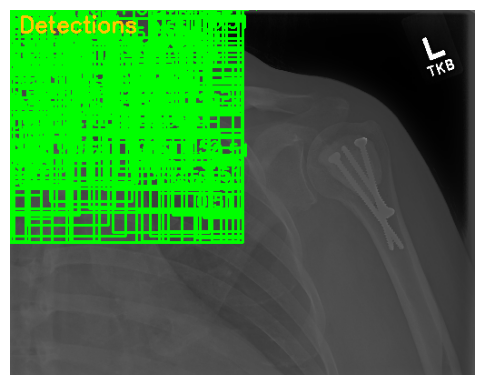

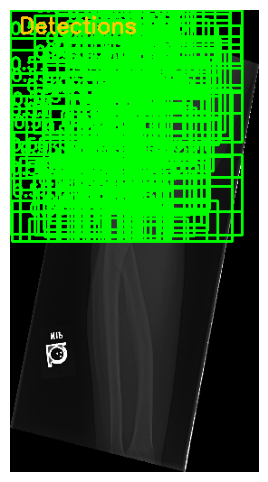

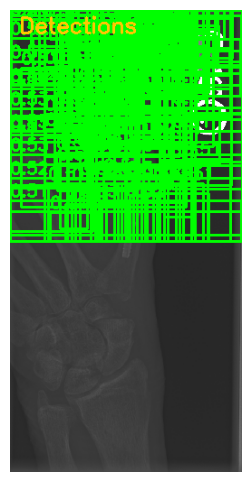

In [27]:
#@title Visualization utility and sample plots
def visualize_detections(image_path, boxes, scores=None, title=None):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(image_path)
    img3 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for i, b in enumerate(boxes):
        x1,y1,x2,y2 = map(int, b)
        cv2.rectangle(img3, (x1,y1), (x2,y2), (0,255,0), 2)
        if scores is not None:
            cv2.putText(img3, f"{scores[i]:.2f}", (x1, max(0,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    if title:
        cv2.putText(img3, title, (10,25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,200,255), 2)
    rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb); plt.axis('off'); plt.show()

# Show a few images with detections
for p in val_dets['image_path'].unique()[:3]:
    bxs = val_dets[val_dets['image_path']==p][['xmin','ymin','xmax','ymax']].values
    scs = val_dets[val_dets['image_path']==p]['score'].values
    visualize_detections(p, bxs, scs, title="Detections")


In [29]:
#@title Temporal tracking (IoU matching across study index)
import re

def parse_patient_and_date(path):
    parts = path.replace("\\","/").split('/')
    patient_id = None; study_id = None
    for p in parts:
        if p.startswith('patient'):
            patient_id = p
        if p.startswith('study'):
            study_id = p
    date_int = None
    if study_id is not None:
        m = re.search(r'study(\d+)', study_id)
        if m: date_int = int(m.group(1))
    return patient_id, date_int

def track_across_time(detections_df, iou_thresh=0.3):
    rows = []
    # group by patient
    patients = detections_df['image_path'].apply(lambda p: parse_patient_and_date(p)[0])
    for patient in patients.unique():
        if patient is None:  # Skip if patient parsing failed
            continue
            
        dfp = detections_df[patients == patient].copy()
        # Fix: properly extract date from the tuple returned by parse_patient_and_date
        dfp['date'] = dfp['image_path'].apply(lambda p: parse_patient_and_date(p)[1] if parse_patient_and_date(p)[1] is not None else 0)
        dfp = dfp.sort_values('date')
        
        tracks = []; next_id = 1
        for _, r in dfp.iterrows():
            cur = np.array([r['xmin'], r['ymin'], r['xmax'], r['ymax']], dtype=float)
            
            # Fix: check for valid bounding box (width > 0 and height > 0)
            if cur[2] <= cur[0] or cur[3] <= cur[1]:  # xmax <= xmin or ymax <= ymin
                continue
                
            assigned = False
            for tr in tracks:
                if iou(cur, tr['last']) >= iou_thresh:
                    tr['last'] = cur
                    rows.append([r['image_path'], patient, *list(map(int, cur)), float(r['score']), tr['id']])
                    assigned = True
                    break
                    
            if not assigned:
                tracks.append({'id': next_id, 'last': cur})
                rows.append([r['image_path'], patient, *list(map(int, cur)), float(r['score']), next_id])
                next_id += 1
                
    return pd.DataFrame(rows, columns=['image_path','patient','xmin','ymin','xmax','ymax','score','track_id'])

tracks = track_across_time(val_dets, iou_thresh=0.3)
tracks.head()

,image_path,patient,xmin,ymin,xmax,ymax,score,track_id
0,MURA-v1.1\valid\XR_SHOULDER\patient11283\study...,patient11283,139,113,245,220,0.564490,1
1,MURA-v1.1\valid\XR_ELBOW\patient11283\study1_n...,patient11283,64,165,170,256,0.525598,2
2,MURA-v1.1\valid\XR_ELBOW\patient11283\study1_n...,patient11283,121,146,211,237,0.525474,1
3,MURA-v1.1\valid\XR_ELBOW\patient11283\study1_n...,patient11283,94,0,186,58,0.522071,3
4,MURA-v1.1\valid\XR_ELBOW\patient11283\study1_n...,patient11283,159,52,224,178,0.521962,4


In [30]:
#@title Save models and CSV outputs
os.makedirs("artifacts", exist_ok=True)
torch.save(det_model.state_dict(), "artifacts/fasterrcnn_mura_fracture.pth")
if USE_PSEUDO_BOXES:
    torch.save(clf.state_dict(), "artifacts/classifier_for_cam.pth")
train_ann.to_csv("artifacts/train_annotations_used.csv", index=False)
valid_ann.to_csv("artifacts/valid_annotations_used.csv", index=False)
val_dets.to_csv("artifacts/valid_detections.csv", index=False)
tracks.to_csv("artifacts/temporal_tracks.csv", index=False)
print("Saved to artifacts/:",
      os.listdir("artifacts"))


Saved to artifacts/: ['classifier_for_cam.pth', 'fasterrcnn_mura_fracture.pth', 'temporal_tracks.csv', 'train_annotations_used.csv', 'valid_annotations_used.csv', 'valid_detections.csv']
